# Part 1

## 1 Data Source

### 1.1 importing packages

In [478]:
# import packages
import numpy as np
import pandas as pd

# visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

#datetime
from datetime import datetime, timedelta

# time series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# standardizing data
from sklearn.preprocessing import StandardScaler
#train test split
from sklearn.model_selection import train_test_split

# logistic regression
from sklearn.linear_model import LogisticRegression

# metric
from sklearn.metrics import classification_report, precision_score

# Tuning Hyperparameter
from sklearn.model_selection import RandomizedSearchCV

# tree models
from sklearn.tree import DecisionTreeClassifier, plot_tree

# random forest
from sklearn.ensemble import RandomForestClassifier

In [479]:
def outlier_limits(df, col):
  quant1=df[[col]].quantile(.25)[0]
  quant3=df[[col]].quantile(.75)[0]
  iqr=quant3 - quant1

  lower=max(min(df[col]), (quant1 - 1.5*iqr))
  upper=min(max(df[col]), (quant3 + 1.5*iqr))

  return lower, upper

In [480]:
# creating a function to determine if a point is a potential outlier
def outlier_detect(row, lower, upper):
  if row >= lower and row <=upper:
    return 'non-outlier'
  else:
    return 'outlier'

In [481]:
# create a function to determine local peaks
def peak(series):
  peaks=[]
  for index, point in enumerate(series):
    if index==0:
      if series[index +1]<point:
        peaks.append('local_peak')
      else:
        peaks.append('not_peak')
    elif index == len(series)-1:
      if series[index -1]<point:
        peaks.append('local_peak')
      else:
        peaks.append('not_peak')
    elif (series[index +1]<point) and (series[index -1]<point):
      peaks.append('local_peak')
    else:
      peaks.append('not_peak')
  return peaks

### 1.2 importing data

In [482]:
login=pd.read_json('/content/drive/MyDrive/machine_learning_projects/ultimate_challenge/logins.json')

## 2 Data Wrangling

In [483]:
# inspecting data
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [484]:
login.head(100)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
95,1970-01-01 23:47:36
96,1970-01-01 23:45:00
97,1970-01-01 23:27:12
98,1970-01-01 23:45:34


### 2.1 checking for inconsistencies

In [485]:
# checking for inconsistencies in year
login.login_time.dt.year.unique()

array([1970])

In [486]:
# checking for inconsistencies in month
login.login_time.dt.month.unique()

array([1, 2, 3, 4])

In [487]:
# checking for inconsistencies in day
login.login_time.dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [488]:
# checking for inconsistencies in hour
login.login_time.dt.hour.unique()

array([20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19])

In [489]:
# checking for inconsistencies in minutes
login.login_time.sort_values().dt.minute.unique()

array([12, 13, 16, 21, 26, 31, 34, 35, 36, 39, 40, 43, 46, 47, 49, 56, 59,
        9, 15, 19, 20, 29, 51, 58,  1,  2,  5,  8, 10, 11, 17, 22, 23, 24,
       25, 55, 57,  4,  6,  7, 14, 18, 27, 30, 33, 37, 38, 41, 44, 45, 48,
       50, 52, 53,  3, 28, 32, 42, 54,  0])

### 2.2 breaking minutes into intervals

In [490]:
type(login.loc[1,'login_time'].year)

int

In [491]:
# creating a function to break time into 15 minute intervals
def convert_time_15min(row):
  """This function takes a datetime object and creates 15 minute intervals
  
  row: row is a row entry formated as a datetime"""

  year=row.year
  month=row.month
  day=row.day
  hour=row.hour
  minute=row.minute
  if minute >=0 and minute<15:
    minute=0
  elif minute >=15 and minute <30:
    minute=15
  elif minute >=30 and minute <45:
    minute=30
  elif minute >=45 and minute <60:
    minute=45
  return datetime(year, month, day, hour, minute)

In [492]:
# converting to 15 minute intervals
login['time_interval']=login.login_time.apply(lambda row: convert_time_15min(row))

# checking results
login.head()

,login_time,time_interval
0,1970-01-01 20:13:18,1970-01-01 20:00:00
1,1970-01-01 20:16:10,1970-01-01 20:15:00
2,1970-01-01 20:16:37,1970-01-01 20:15:00
3,1970-01-01 20:16:36,1970-01-01 20:15:00
4,1970-01-01 20:26:21,1970-01-01 20:15:00


## 3 EDA

### 3.1 calculating login counts

In [493]:
# getting the counts
login_count=login.groupby('time_interval')['login_time'].count()

# creating data frame
login_count_df=pd.DataFrame(login_count.values, index=login_count.index, columns=['login_count'])

# checking results
login_count_df.head()

,login_count
time_interval,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [494]:
login_count_df.shape

(9381, 1)

### 3.2 checking for duplicates

In [495]:
# sorting by time
login_count_df=login_count_df.sort_values('time_interval')

login_count_df

,login_count
time_interval,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [496]:
login_count_df.index.duplicated(keep='first').sum()

0

### 3.3 descriptive statistics

In [497]:
login_count_df.describe()

,login_count
count,9381.000000
mean,9.928792
std,8.263146
min,1.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,73.000000


### 3.4 histogram

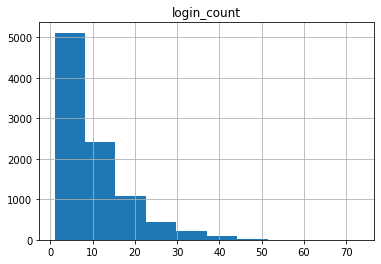

In [498]:
# plotting the data
login_count_df.hist()
plt.show()

### 3.5 boxplot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


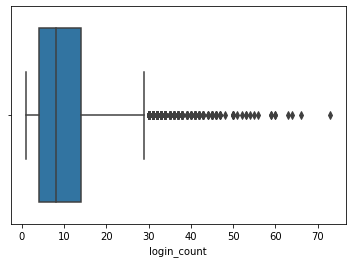

In [499]:
sns.boxplot(login_count_df.login_count)
plt.show()

### 3.6 outlier analysis

#### 3.6.1 detecting potential outliers

In [500]:
# calculating lower and upper limits for potential outliers
lower, upper=outlier_limits(login_count_df, 'login_count')

In [501]:
# creating outlier column
login_count_df['outlier']=login_count_df.login_count.apply(lambda row: outlier_detect(row, lower, upper))

# checking results
login_count_df.sort_values('login_count', ascending=False).head()

,login_count,outlier
time_interval,,
1970-03-01 04:30:00,73,outlier
1970-04-04 05:30:00,66,outlier
1970-04-04 01:30:00,64,outlier
1970-04-04 01:15:00,63,outlier
1970-04-04 05:00:00,60,outlier


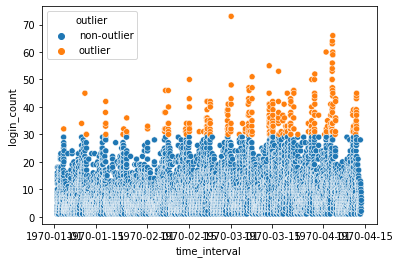

In [502]:
sns.scatterplot(x=login_count_df.index, y=login_count_df.login_count, hue=login_count_df.outlier)
plt.show()

In [503]:
type(login_count_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

#### 3.6.2 grouping data by month and day

In [504]:
login_count_df.reset_index(inplace=True)

In [505]:
# group by days
max_login_num=login_count_df.groupby(pd.Grouper(key='time_interval', freq='D'))['login_count'].sum()

# create data frame
max_day_login_df=pd.DataFrame(max_login_num.values, index=max_login_num.index, columns=['num_login'])

# checking results
max_day_login_df.head()

,num_login
time_interval,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


#### 3.6.3 finding local peaks

In [506]:
del max_login_num

In [507]:
# finding peaks
max_day_login_df['peak']=peak(max_day_login_df.num_login.values)

# inspect results
max_day_login_df.head()

,num_login,peak
time_interval,,
1970-01-01,112,not_peak
1970-01-02,681,not_peak
1970-01-03,793,local_peak
1970-01-04,788,not_peak
1970-01-05,459,not_peak


In [508]:
peeks=max_day_login_df[max_day_login_df.peak=='local_peak']
peeks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 1970-01-03 to 1970-04-12
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   num_login  19 non-null     int64 
 1   peak       19 non-null     object
dtypes: int64(1), object(1)
memory usage: 456.0+ bytes


In [509]:
# reseting index
peeks.reset_index(inplace=True)

# finding the period
peeks['period']=peeks.time_interval.diff().abs()

# checking results
peeks.head(30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,time_interval,num_login,peak,period
0,1970-01-03,793,local_peak,NaT
1,1970-01-07,648,local_peak,4 days
2,1970-01-10,1054,local_peak,3 days
3,1970-01-17,1064,local_peak,7 days
4,1970-01-20,531,local_peak,3 days
5,1970-01-24,926,local_peak,4 days
6,1970-02-01,870,local_peak,8 days
7,1970-02-08,1262,local_peak,7 days
8,1970-02-14,1173,local_peak,6 days
9,1970-02-21,1479,local_peak,7 days


In [510]:
# average days between peeks
peeks.dropna(inplace=True)

# groupby month
peeks.groupby(pd.Grouper(key='time_interval', freq='M'))['period'].median()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


time_interval
1970-01-31   4 days
1970-02-28   7 days
1970-03-31   5 days
1970-04-30   7 days
Freq: M, Name: period, dtype: timedelta64[ns]

### 3.7 time series plot

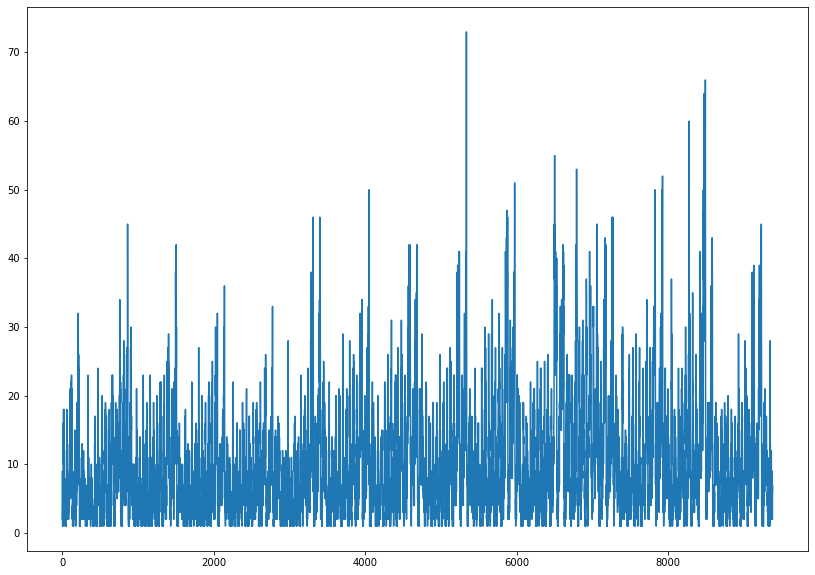

In [511]:
fig, ax=plt.subplots(figsize=(14,10))
login_count_df.login_count.plot(ax=ax)
plt.show()

#### 3.7.1 testing stationarity

In [512]:
login_count_df.head()

,time_interval,login_count,outlier
0,1970-01-01 20:00:00,2,non-outlier
1,1970-01-01 20:15:00,6,non-outlier
2,1970-01-01 20:30:00,9,non-outlier
3,1970-01-01 20:45:00,7,non-outlier
4,1970-01-01 21:00:00,1,non-outlier


In [513]:
adfuller(login_count_df.login_count)

(-10.389047674536704,
 2.043655345876298e-18,
 38,
 9342,
 {'1%': -3.431050181732143,
  '5%': -2.8618494362749733,
  '10%': -2.5669347078446885},
 54276.93006095418)

With a p-value approximately equal to zero, we reject the null. Since we can reject the null hypothesis for adfuller, there is sufficient evidence that the data is stationary.

#### 3.7.2 seasonality

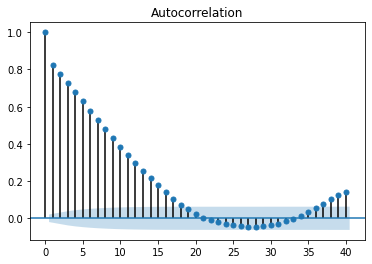

In [514]:
plot_acf(login_count_df.login_count)
plt.show()

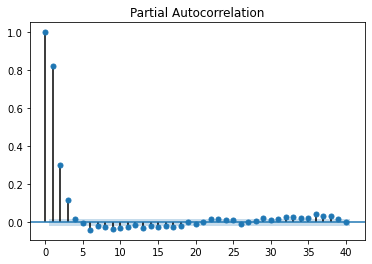

In [515]:
plot_pacf(login_count_df.login_count)
plt.show()

The autocorrelation and partial correlation functions suggests there is no seasonality; however, the graph of the time series shows seasonality.

#### 3.7.3 smoothing

In [516]:
def plot_smooth_ts(df, window, figure_size):
  fig, ax=plt.subplots(figsize=figure_size)
  smoothing_mean=df.rolling(window=window).mean()
  smoothing_mean=smoothing_mean.dropna()

  ax.plot(smoothing_mean)
  plt.show()

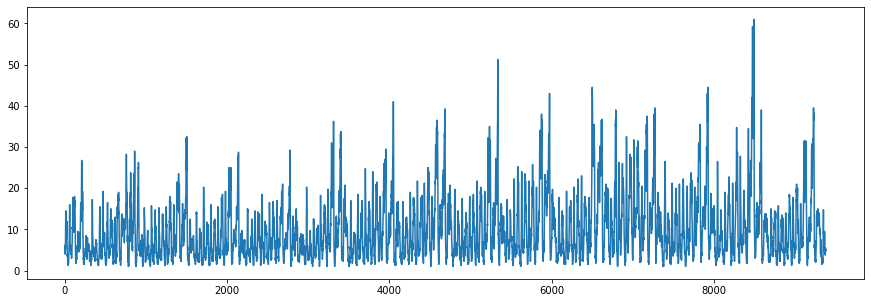

In [517]:
# hourly data
plot_smooth_ts(login_count_df, 4, (15,5))

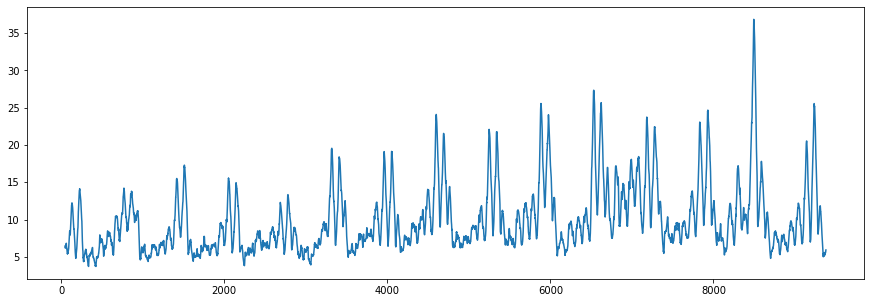

In [518]:
# 12 hour
plot_smooth_ts(login_count_df, 48, (15,5))

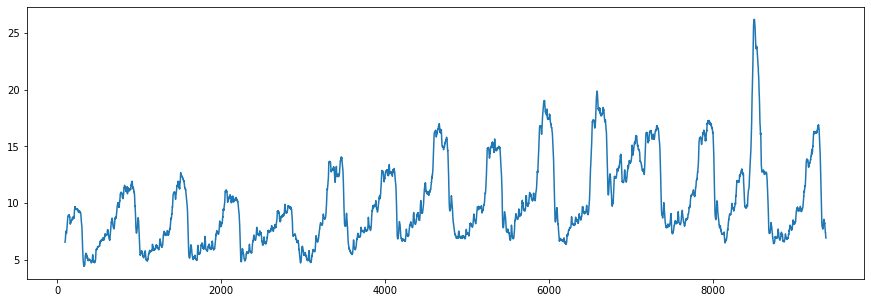

In [519]:
# daily
plot_smooth_ts(login_count_df, 96, (15,5))

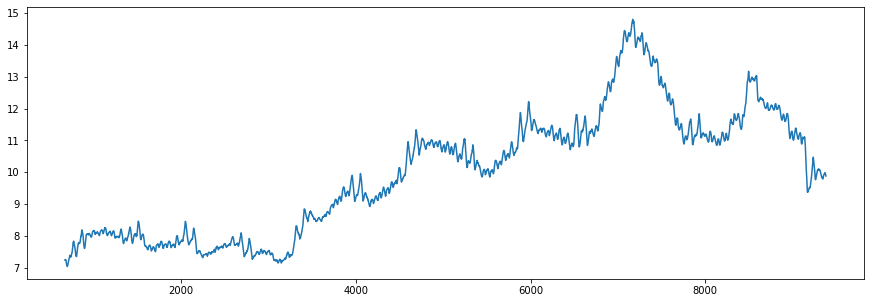

In [520]:
# weekly
plot_smooth_ts(login_count_df, 672, (15,5))

#### 3.7.4 decomposition

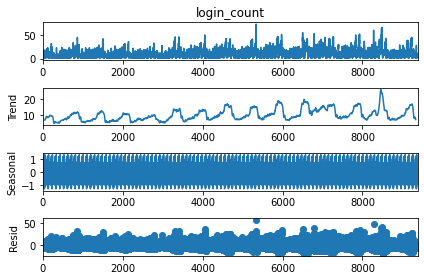

In [521]:
seasonal_decompose(login_count_df.login_count, period=96).plot()
plt.show()

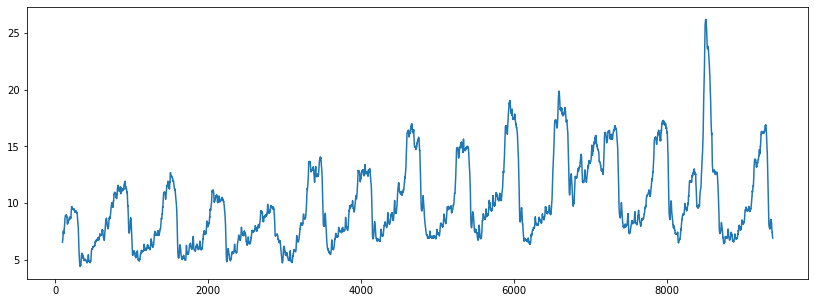

In [522]:
# daily
fig, ax=plt.subplots(figsize=(14,5))
daily_mean=login_count_df.rolling(window=96).mean()
daily_mean=daily_mean.dropna()
ax.plot(daily_mean.login_count)
plt.show()

In [523]:
del ax, daily_mean, fig, login, login_count, login_count_df, lower, max_day_login_df, peeks, upper

## 4 Summary

The dates for the data are likely incorrect. All of the login data comes from 1970. Although the internet did exist in a rudimentary form in the 70's, it was not wide spread enough that people would be logging in every 15 minutes; thus, the year is mostly incorrect. 

There is an average of 9 logins every 15 minutes. Additionally, there appears to be a seasonal component on the daily level where a peak occurs between every 3 to 7 days depending on the month.


# Part 2

1) If there is a statistically significant increase in the percentage of profits from cross city trips, I would say the experiment is a success. Since the goal of most companies is to make a profit, ultimate is trying this experiment to increase revenue; however, since they will reimburse toll costs, there costs will increase. Therefore, just raising revenue is not a good measure because costs may rise by the same or even more, which would hurt the company. We would use percentage of profits from cross city trips because cross city trips may only constitute a small percentage of profits that would be obscured if we only focused on increasing profits. 

2a) To carry out this experiment, we would use stratified sampling to divide all drives into two groups: test group and control group. The strata would be based on the distance from the driver's home to down town of the other city. Since drivers who are closer to the other city may be more inclined to take cross city fares than those who are farther away, so stratifying the samples based on distance would help us from oversampling from people who are closer to the other city. The test group would be told that the company will reimburse all toll fees between the two cities. This experiment will be conducted for a month. The percentage of profits from cross town trips will be calculated for both groups. 

2b) Next, we will carry out a one tail two sample t-test. Where the null hypothesis is that the percentage of profits from cross town trips for the test group is less than or equal to the percentage for the control group. The alternative hypothesis is the percentage is higher for the test group than the control group.

2c) If the one tailed two sample t-test produces a p-value of .01 or smaller, then we would conclude that reimbursing tolls statistically increases profits from cross city trips, and I would recommend ultimate to adopt the policy for all drivers.


# Part 3

### 3.1 Data Source

In [524]:
retention=pd.read_json('/content/drive/MyDrive/machine_learning_projects/ultimate_challenge/ultimate_data_challenge.json')

In [525]:
retention.shape

(50000, 12)

In [526]:
retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### 3.2 Data Wrangling

#### 3.2.1 Data Types

In [527]:
retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [528]:
retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [529]:
# convert signup_date to date
retention['signup_date']=pd.to_datetime(retention.signup_date)

# convert last_trip_date to date
retention['last_trip_date']=pd.to_datetime(retention.last_trip_date)

# check results
retention.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

#### 3.2.2 Check String Formats

In [530]:
# checking unique city values
retention.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [531]:
# inspecting phone type format
retention.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [532]:
# inspecting ultimate_black_user
retention.ultimate_black_user.unique()

array([ True, False])

#### 3.2.3 Range Constraints

##### 3.2.3.1 Integer and Float

In [533]:
numeric_data=retention.select_dtypes(['int', 'float'])

# inspecting results
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    41878 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   weekday_pct             50000 non-null  float64
 5   avg_dist                50000 non-null  float64
 6   avg_rating_by_driver    49799 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.7 MB


In [534]:
numeric_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [535]:
del numeric_data

##### 3.2.3.2 Dates

In [536]:
retention.select_dtypes('datetime').describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18 00:00:00,2014-06-29 00:00:00
freq,2948,2036
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-01-31 00:00:00,2014-07-01 00:00:00


##### 3.2.3.3 Summary

If a rider used the service in the last 30 days, we say they are retained. Since the latest trip date is July 1st 2014, we will say a user who used the service between June 1st and July 1st is retained.

#### 3.2.4 Duplicates

Each index represents a different user, so this data set has 5,000 users, so the only unique values is the index because there are multiple people who signed up on the same date in the same city with the same type of phone.

#### 3.2.5 Missing Values

##### 3.2.5.1 Number of Missing Values

In [537]:
# checking the number of missing values for each column
retention.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

##### 3.2.5.2 Filling Missing Numeric Values

In [538]:
retention[['avg_rating_of_driver','avg_rating_by_driver']].describe()

,avg_rating_of_driver,avg_rating_by_driver
count,41878.000000,49799.000000
mean,4.601559,4.778158
std,0.617338,0.446652
min,1.000000,1.000000
25%,4.300000,4.700000
50%,4.900000,5.000000
75%,5.000000,5.000000
max,5.000000,5.000000


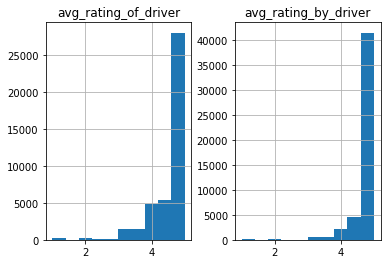

In [539]:
retention[['avg_rating_of_driver','avg_rating_by_driver']].hist()
plt.show()

Since both average rating of driver and rider is left skewed, we will fill the missing values with the median values

In [540]:
median_driver_rating=retention.avg_rating_of_driver.median()
median_rider_rating=np.median(retention.avg_rating_by_driver)

In [541]:
# replace na with median values
retention[['avg_rating_of_driver', 'avg_rating_by_driver']]=retention[['avg_rating_of_driver', 'avg_rating_by_driver']].fillna(retention[['avg_rating_of_driver', 'avg_rating_by_driver']].median())

# check results
retention.isna().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

##### 3.2.5.3 Filling Missing Phone Information

In [542]:
retention.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [543]:
retention[['phone']]=retention[['phone']].fillna('iPhone')

# check results
retention.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [544]:
# checking values for phone
retention.phone.unique()

array(['iPhone', 'Android'], dtype=object)

##### 3.2.5.4 Summary

We fill the missing average driver and rider rating data with the median rating data for each variable, respectively. Then we replaced the missing categorical phone data with the most widely used phone type, which is iPhone.

### 3.3 EDA

#### 3.3.1 Creating Retention Variable

In [545]:
def rider_retention(row):
  """This function creates a variable that takes a 1 if the users was retain and 0 otherwise. 
  If the number of days between last ride and July 1st 2014 is less than or equal to 30, 
  this function will give the user a 1. All other users will have a zero."""

  if datetime(2014, 7, 1) - row <= timedelta(days=30):
    return 'retained'
  else:
    return 'not retained'

In [546]:
retention['retention']=retention.last_trip_date.apply(lambda row: rider_retention(row))

# inspect results
retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,retained
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,not retained
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,not retained
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,retained
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,not retained


In [547]:
# inspecting data types
retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retention               50000 non-null  object

In [548]:
# ensuring no retention mismatch
retention.retention.unique()

array(['retained', 'not retained'], dtype=object)

#### 3.3.2 Descriptive Statistics

In [549]:
retention.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.650038,1.074764,8.849536,60.926084,5.796827,4.779050
std,3.792684,0.575601,0.222336,19.958811,37.081503,5.707357,0.445974
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [550]:
retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retention               50000 non-null  object

In [551]:
len(retention.phone)

50000

In [552]:
# proportion of retained and not retained
retain_grp=retention.groupby('retention')['phone'].count().divide(50000)
retain_grp_df=pd.DataFrame(retain_grp.values,index=retain_grp.index, columns=['proportion'])
retain_grp_df

,proportion
retention,
not retained,0.62392
retained,0.37608


In [553]:
del retain_grp

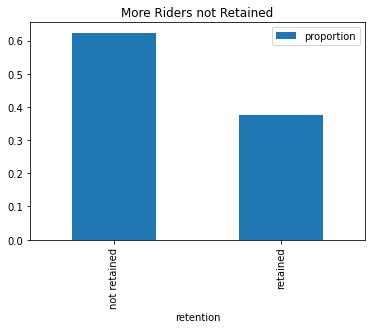

In [554]:
retain_grp_df.plot.bar()
plt.title('More Riders not Retained')
plt.show()

In [555]:
del retain_grp_df

#### 3.3.4 Retention vs Ultimate Black Users

In [556]:
def stacked_bar_chart(df, group, subgroup,variable):
  df.reset_index(inplace=True)
  df2=df.pivot_table(index=group, columns=subgroup, values=variable)
  
  row_sum=df2.sum(axis=1)
  df2.div(row_sum.values, axis=0).plot.bar(stacked=True)
  plt.show()

 

In [557]:
retain_grp=retention.groupby(['retention','ultimate_black_user'])['phone'].count()

#creating data frame
retain_grp_df=pd.DataFrame(retain_grp.values, index=retain_grp.index, columns=['proportion_of_riders'])

#inspecting results
retain_grp_df

proportion_of_riders
retention    ultimate_black_user                      
not retained False                               21839
             True                                 9357
retained     False                                9307
             True                                 9497

In [558]:
retain_grp_df.pivot_table(index='ultimate_black_user', columns='retention', values='proportion_of_riders')

retention,not retained,retained
ultimate_black_user,,
False,21839,9307
True,9357,9497


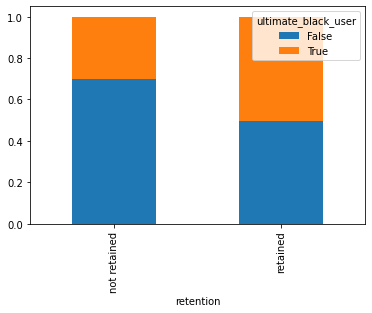

In [559]:
# retention bar chart
stacked_bar_chart(retain_grp_df, 'retention', 'ultimate_black_user','proportion_of_riders')

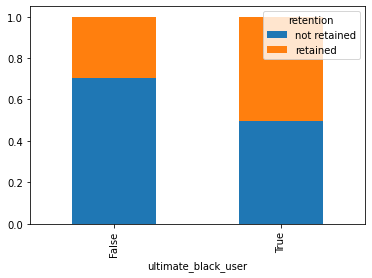

In [560]:
# ultimate black user chart
stacked_bar_chart(retain_grp_df, 'ultimate_black_user','retention', 'proportion_of_riders')

In [561]:
del retain_grp_df

#### 3.3.5 Retention and City

In [562]:
# group by retention and city
retain_city=retention.groupby(['retention','city'])['phone'].count()

# create a data frame
retain_city_df=pd.DataFrame(retain_city.values, index=retain_city.index, columns=['count'])

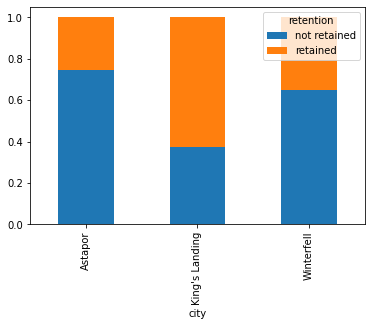

In [563]:
stacked_bar_chart(retain_city_df, 'city', 'retention', 'count')

In [564]:
del retain_city, retain_city_df

In [565]:
retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,retained
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,not retained
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,not retained
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,retained
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,not retained


#### 3.3.6 trips_in_first_30_days and Retention

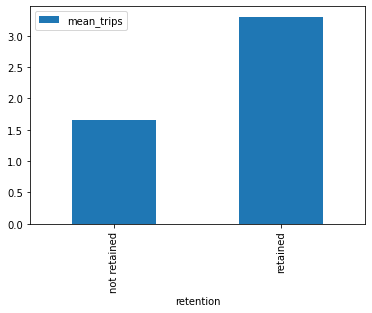

In [566]:
retain_visits=retention.groupby(['retention'])['trips_in_first_30_days'].mean()

# create data frame
retain_visits_df=pd.DataFrame(retain_visits.values, index=retain_visits.index, columns=['mean_trips'])

# inspect results
retain_visits_df.plot.bar()
plt.show()

#### 3.3.7 driver's ratings and retention

In [567]:
retention.groupby('retention')['avg_rating_of_driver'].mean()

retention
not retained    4.668397
retained        4.619581
Name: avg_rating_of_driver, dtype: float64

#### 3.3.8 user's ratings by drivers and retention

In [568]:
retention.groupby('retention')['avg_rating_by_driver'].mean()

retention
not retained    4.788588
retained        4.763226
Name: avg_rating_by_driver, dtype: float64

#### 3.3.9 Weekday percentage and retention

In [569]:
retention.groupby('retention')['weekday_pct'].mean()

retention
not retained    60.647032
retained        61.389034
Name: weekday_pct, dtype: float64

#### 3.3.10 surge percentage and retention

In [570]:
retention.groupby('retention')['surge_pct'].mean()

retention
not retained    8.666739
retained        9.152797
Name: surge_pct, dtype: float64

#### 3.3.11 distance and retention

In [571]:
retention.groupby('retention')['avg_dist'].mean()

retention
not retained    6.207939
retained        5.114788
Name: avg_dist, dtype: float64

Roughly 38% of riders in the dataset were retained. Thus, the data is unbalanced. From the 100% stacked bar chart, it appears that being an ultimate black user is associated with a higher probability of staying a customer. King's Landing has larger portion of retention than the other three cities. It appears the more trips a person takes, the more likely they are to stay active; however, it is most likely that active users tend to take more trips. Average driver and user ratings appears to have no impact on retention. Retained users have a slightly higher percentage of weekday trips and percentage of surge pricing. Surprisingly, user's that are not retained traveled longer distances on average, which may be people who travel a long distance infrequently.

### 4.1 Preprocessing

#### 4.1.1 Encoding Response Variable

In [572]:
response=[1 if row=='retained' else 0 for row in retention.retention]

# inspecting results
response[:5]

[1, 0, 0, 1, 0]

In [573]:
# swapping retention column for response
retention['retention']=response

# checking results
retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [574]:
del response

#### 4.1.2 Encoding Predicter Variables

In [575]:
# encoding dummy city variable
city_dummies=pd.get_dummies(retention.city, drop_first=False)

# encode phone dummy variabe
phone_dummies=pd.get_dummies(retention.phone, drop_first=False)

# changing ultimate black user to 1 and 0
ultimate_user_black=[1 if row==True else 0 for row in retention.ultimate_black_user]

# switching columns
retention['ultimate_black_user']=ultimate_user_black

# merge retention, city, and phone dummies
retention_dummies=retention.merge(city_dummies, how='left',left_index=True, right_index=True).merge(phone_dummies, how='left',left_index=True, right_index=True)

In [576]:
# drop city and phone columns
retention_dummies.drop(columns=['city','phone'], inplace=True)

# inspect results
retention_dummies.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


In [577]:
del city_dummies, phone_dummies, ultimate_user_black

#### 4.1.3 Droping Datetime Columns

In [578]:
retention_dummies.drop(columns=['signup_date','last_trip_date'], inplace=True)

# inspect results
retention_dummies.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


#### 4.1.4 Extracting X and y

In [579]:
# seperating X and y variables
X=retention_dummies.drop(columns=['retention'])
y=retention_dummies.retention

In [580]:
del retention_dummies

#### 4.1.4 Standardized Data

In [581]:
#initiate scaler
scaler=StandardScaler()

# fit and transform data
X_scaled=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

In [582]:
del scaler

#### 4.1.6 Train Test Split

In [583]:
# train test split
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X_scaled, y, test_size=.25, random_state=42)

X_train_logit.shape, y_train_logit.shape, X_test_logit.shape, y_test_logit.shape 

((37500, 13), (37500,), (12500, 13), (12500,))

In [584]:
del X_scaled

### 4.2 Model Training

#### 4.2.1 Logistic Model

In [585]:
# initiate logistic regression object
logit=LogisticRegression()

# fit model to training data
logit_results=logit.fit(X_train_logit, y_train_logit)

In [586]:
pd.DataFrame(logit_results.coef_, columns=logit_results.feature_names_in_)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,iPhone
0,0.464181,-0.073904,-0.049037,0.097181,0.422558,-0.005252,-0.199989,-0.062884,-0.303579,0.435097,-0.064263,-0.245716,0.245716


In [587]:
# classification report in sample
print(classification_report(y_train_logit, logit_results.predict(X_train_logit)))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     23396
           1       0.67      0.49      0.57     14104

    accuracy                           0.72     37500
   macro avg       0.70      0.67      0.68     37500
weighted avg       0.71      0.72      0.71     37500



In [588]:
del logit, logit_results

##### 4.2.1.1 Hyperparamter Training

In [589]:
# # initiate logistic regression model
# model=LogisticRegression(C=1)

# # create search grid
# grid_params={'C':np.arange(1,100, 10)}

# # initiate grid search
# grid_search=RandomizedSearchCV(model, param_distributions=grid_params, scoring='precision', random_state=42)

# # fit grid_search
# grid_results=grid_search.fit(X_train, y_train)

In [590]:
# get best params
# grid_results.best_params_

In [591]:
# del model, grid_params, grid_search

##### 4.2.1.2 Model using Best Parameter

In [592]:
# initiating model
model=LogisticRegression(C=11)

# model fitting
logit_results=model.fit(X_train_logit, y_train_logit)

In [593]:
# results
print(classification_report(y_train_logit, logit_results.predict(X_train_logit)))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     23396
           1       0.67      0.49      0.57     14104

    accuracy                           0.72     37500
   macro avg       0.70      0.67      0.68     37500
weighted avg       0.71      0.72      0.71     37500



In [594]:
pd.DataFrame(logit_results.coef_, columns=logit_results.feature_names_in_)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,iPhone
0,0.464275,-0.073913,-0.049082,0.097234,0.422621,-0.005254,-0.200019,-0.062894,-0.303617,0.435149,-0.064269,-0.245739,0.245739


##### 4.2.1.3 Summary

The number of trips in the first 30 days and being ultimate black users are the most import determinates of a user continuing to use the syste. For each additional ride in the first 30 days increases the likelhood the rider will stay by 46% while an ultimate black user is 42% more likely to continue to use ultimate.

#### 4.2.2 Decision Tree

##### 4.2.2.1 Pre-Processing Data

In [595]:
# train test split with unscaled data
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=.25, random_state=42)

##### 4.2.2.2 Hyperparamter Tuning

In [596]:
# # initiating the decision tree
# decision_tree=DecisionTreeClassifier(max_depth=10, min_samples_split=1)

# # create params list
# grid_params={'max_depth':np.arange(10,100,5),'min_samples_split':np.arange(1,40,5)}

# # initiate randomizedsearchgrid
# grid_search=RandomizedSearchCV(decision_tree, param_distributions=grid_params, scoring='precision', random_state=42)

# # fit the grid search
# grid_search_fit=grid_search.fit(X_train, y_train)

In [597]:
# grid_search_fit.best_params_


In [598]:
# del decision_tree, grid_params, grid_search, grid_search_fit

##### 4.2.2.3 Training Best Model

In [599]:
#initating the model
decision_tree=DecisionTreeClassifier(min_samples_split=21, max_depth=15)

# fit the model
decision_tree_results=decision_tree.fit(X_train, y_train)

In [600]:
fig=plt.figure(figsize=(100,100))
_=plot_tree(decision_tree_results, impurity=False, feature_names=X.columns)

Output hidden; open in https://colab.research.google.com to view.

In [601]:
# inspecting results
print(classification_report(y_train, decision_tree_results.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88     23396
           1       0.81      0.76      0.78     14104

    accuracy                           0.84     37500
   macro avg       0.83      0.82      0.83     37500
weighted avg       0.84      0.84      0.84     37500



##### 4.2.2.5 Feature Importance

In [602]:
decision_tree_results.feature_names_in_

array(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'Astapor', "King's Landing", 'Winterfell',
       'Android', 'iPhone'], dtype=object)

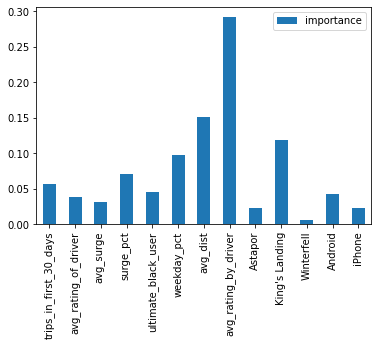

In [603]:
pd.DataFrame(decision_tree_results.feature_importances_, index=decision_tree_results.feature_names_in_, columns=['importance']).plot.bar()
plt.show()

##### 4.2.2.6 Summary

Decision tree has a precision score of 81%; thus, 81% of user who were predicted to stay actually stayed. From feature importance, average rating by drive, average distance, users from King's Landing, and weekday percentage have the largest impact on user retention.

#### 4.2.3 Random Forest

##### 4.2.3.1 Hyperparameter Tuning

In [604]:
# # initiate random forest
# rand_forest=RandomForestClassifier(n_estimators=100,max_depth=10, min_samples_split=1, oob_score=True, random_state=42)

# # create grid_params
# grid_params={'n_estimators':np.arange(100,1000,100),'max_depth':np.arange(10,100,10),'min_samples_split':np.arange(1,40,5)}

# # create randomized search cv
# grid_search=RandomizedSearchCV(rand_forest, param_distributions=grid_params, random_state=42, scoring='precision')

# # fit random cv
# grid_search_fit=grid_search.fit(X_train, y_train)

In [605]:
# grid_search_fit.best_params_

##### 4.2.3.2 Training Best Model

In [606]:
# initiate model
rand_forest=RandomForestClassifier(n_estimators=700, min_samples_split=36, max_depth=60, oob_score=True, random_state=42)

# fit model
rand_forest_results=rand_forest.fit(X_train, y_train)

In [607]:
# results
print(classification_report(y_train, rand_forest_results.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     23396
           1       0.81      0.71      0.76     14104

    accuracy                           0.83     37500
   macro avg       0.83      0.81      0.81     37500
weighted avg       0.83      0.83      0.83     37500



##### 4.2.3.3 Feature Importance

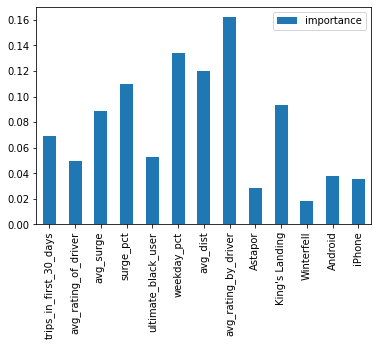

In [608]:
pd.DataFrame(rand_forest_results.feature_importances_, index=rand_forest_results.feature_names_in_, columns=['importance']).plot.bar()
plt.show()

##### 4.2.3.4 Summary

Random forest gives the same precision score of 81% as the decision tree. Feature Importance is similar as well with average rating by driver, weekday percentage, average distance, and surge percentage.

#### 4.2.4 Out of Sample Results

##### 4.2.4.1 Logistic Regression

In [613]:
precision_score(y_test_logit, logit_results.predict(X_test_logit))

0.6648831315122501

##### 4.2.4.2 Decision Tree

In [615]:
precision_score(y_test, decision_tree_results.predict(X_test))

0.6754149842978915

##### 4.2.4.3 Random Forests

In [616]:
precision_score(y_test, rand_forest_results.predict(X_test))

0.7380952380952381

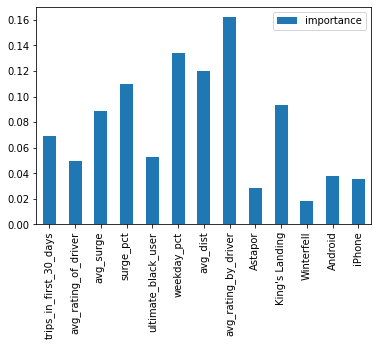

In [619]:
pd.DataFrame(rand_forest_results.feature_importances_, index=rand_forest_results.feature_names_in_, columns=['importance']).plot.bar()
plt.show()

### 4.3 Summary

When assessing classification models, we may want to minimize false positives or false negatives. False positive means we predicted a user would stay with the service, but they don't while false negative means we predict they won't stay with the service, but they stay with the service. A false negative costs ultimate money through lost revenue while they gain money for false negative; thus, I want to minimize false positives. We can minimize false positives by maximizing precision score.

Random Forest models has the best precision score of 73% for out of sample. Additionally, I tried a logistic regression model and decision tree.  

The four most important variables for predicting retention are average rating by driver, weekday percentage, average distance, and surge percentage, respectively.

From the most important variables, ultimate can increase retention by getting users to travel more during the weekday through reduced weekday pricing. They may be able to increase the average distance by giving a discount on longer trips.